In [1]:
# Loading necessary modules.
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from os import fspath
%matplotlib inline
import seaborn as sns
import math
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.analysis.align import AlignTraj
from MDAnalysis.analysis.align import AverageStructure
from MDAnalysis.analysis.rms import RMSD, RMSF
from MDAnalysis.analysis.pca import PCA, cosine_content
from MDAnalysis.analysis import diffusionmap
from MDAnalysis.transformations.positionaveraging import PositionAverager
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.patches as patches

/home/giacomo/micromamba/envs/QCB/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
comm_path = "/home/giacomo/comp_bio/cbp_final/data_other/umbrella/02_processed/simulations_nbc/"

In [39]:
sim_number = "313"

# Pressure and Temp

In [40]:
window_size = 100

In [41]:
data = np.loadtxt(comm_path + "sim_" + sim_number + ".xvg", comments = ["@", "#"])
tem_df = pd.DataFrame({"t": data[:, 0], "T": data[:, 1], "P": data[:, 2]})

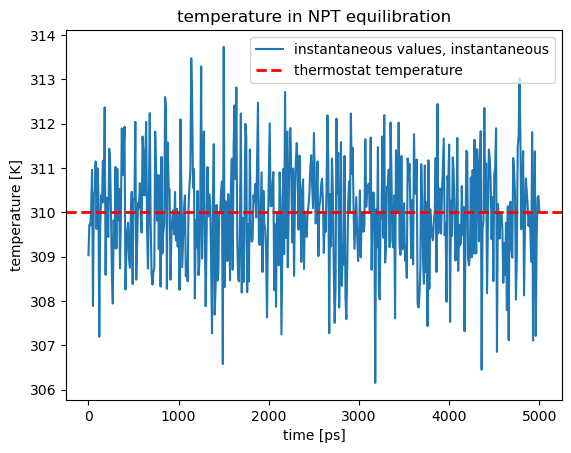

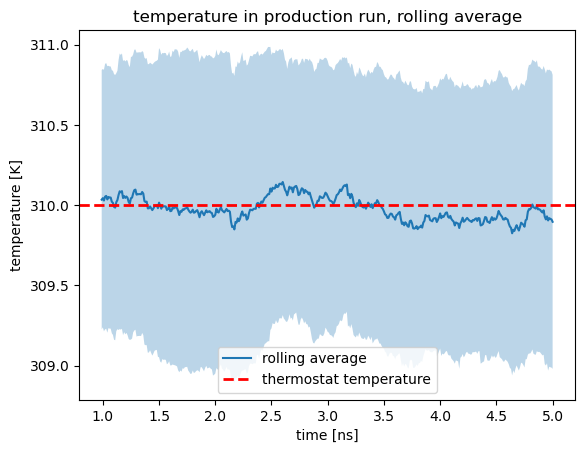

In [42]:
plt.plot(tem_df["t"], tem_df["T"], label = "instantaneous values, instantaneous")
plt.title("temperature in NPT equilibration")
plt.xlabel("time [ps]")
plt.ylabel("temperature [K]")
plt.axhline(y=310, color='r', linestyle='--', linewidth=2, label = "thermostat temperature")
plt.legend()
plt.show()

errors_temp = np.sqrt(tem_df["T"].rolling(window_size).var() / 2)
# errors_temp = 0.1
cum_temp = tem_df["T"].rolling(window_size).mean()
plt.plot(tem_df["t"] / 1000, cum_temp, label = "rolling average")
plt.fill_between(tem_df["t"] / 1000, cum_temp + errors_temp, cum_temp - errors_temp, alpha=0.3)
plt.title("temperature in production run, rolling average")
plt.xlabel("time [ns]")
plt.ylabel("temperature [K]")
plt.axhline(y=310, color='r', linestyle='--', linewidth=2, label = "thermostat temperature")
plt.legend()
plt.show()

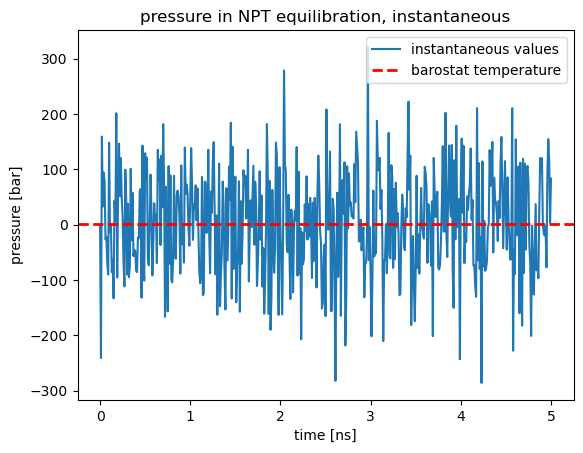

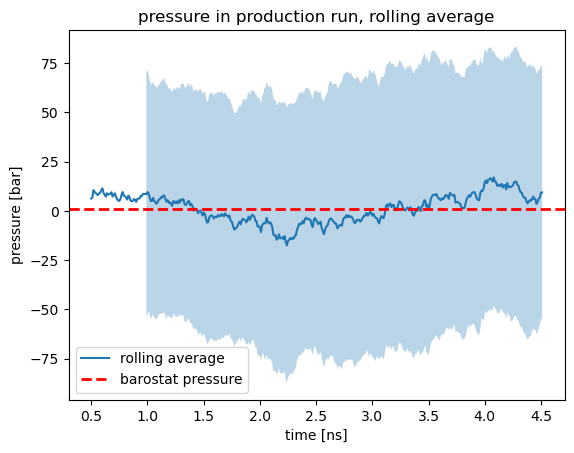

In [43]:
plt.plot(tem_df["t"] / 1000, tem_df["P"], label = "instantaneous values")
plt.title("pressure in NPT equilibration, instantaneous")
plt.xlabel("time [ns]")
plt.ylabel("pressure [bar]")
plt.axhline(y=1, color='r', linestyle='--', linewidth=2, label = "barostat temperature")
plt.legend()
plt.show()

cum_press = tem_df["P"].rolling(window_size, center = True).mean()
errors_press = np.sqrt(tem_df["P"].rolling(window_size).var() / 2)
plt.plot(tem_df["t"] / 1000, cum_press, label = "rolling average")
plt.fill_between(tem_df["t"] / 1000, cum_press + errors_press, cum_press - errors_press, alpha=0.3)
plt.title("pressure in production run, rolling average")
plt.xlabel("time [ns]")
plt.ylabel("pressure [bar]")
plt.axhline(y=1, color='r', linestyle='--', linewidth=2, label = "barostat pressure")
# plt.axhline(y=0, color='r', linestyle='--', linewidth=2, label = "barostat pressure")
plt.legend()
plt.show()

# MDA

In [44]:
config_file = comm_path + "sim_" + sim_number + ".tpr"
traj_file = comm_path + "sim_" + sim_number + "_nbc.xtc"
aligned_traj_file = comm_path + "sim_" + sim_number + "_cat.xtc"

In [45]:
already_done = False 
sel = "name CA and not resid 18 to 27 and not resid 41 to 46"
if not already_done: 

    traj = mda.Universe(config_file, traj_file)
    av = AverageStructure(traj, ref_frame=0).run()
    aligner = AlignTraj(traj,av.results.universe,select=sel,filename = aligned_traj_file)    
    aligner.run()

In [46]:
aligned_traj = mda.Universe(config_file, aligned_traj_file)
ref_traj = mda.Universe(config_file, aligned_traj_file)    
ref_traj.trajectory[0]

/home/giacomo/micromamba/envs/QCB/lib/python3.12/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


< Timestep 0 with unit cell dimensions [ 68.18697  68.18697 175.33781  90.       90.       90.     ] >

Text(0, 0.5, 'RMSD $[\\AA]$')

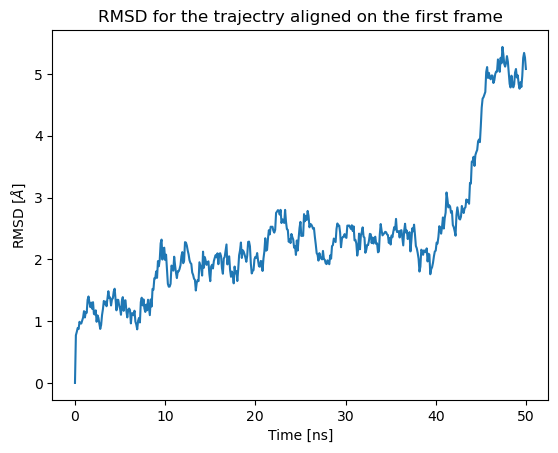

In [47]:
R = RMSD(aligned_traj, ref_traj, select=sel).run()

plt.title("RMSD for the trajectry aligned on the first frame")
plt.plot(R.results.rmsd[:,0] / 10, R.results.rmsd[:,2])
plt.xlabel('Time [ns]')
plt.ylabel(r'RMSD $[\AA]$')

In [48]:
pca = PCA(aligned_traj, select=sel)
pca.run()

pca_space = pca.transform(aligned_traj.select_atoms(sel),2)
pca_data = pd.DataFrame(pca_space, columns=['first_comp','second_comp'])
pca_data["group"] = (pca_data.index // 40) * 4

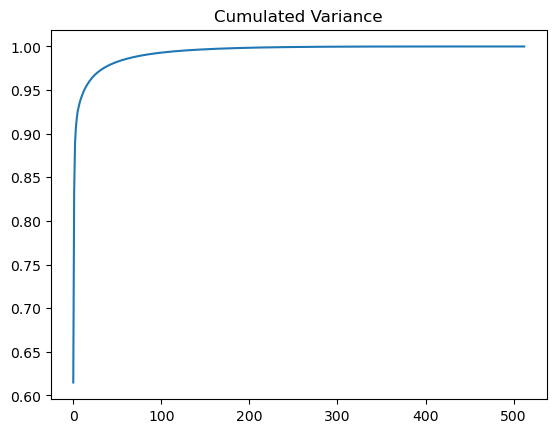

In [49]:
plt.title('Cumulated Variance')
plt.plot(pca.results.cumulated_variance)

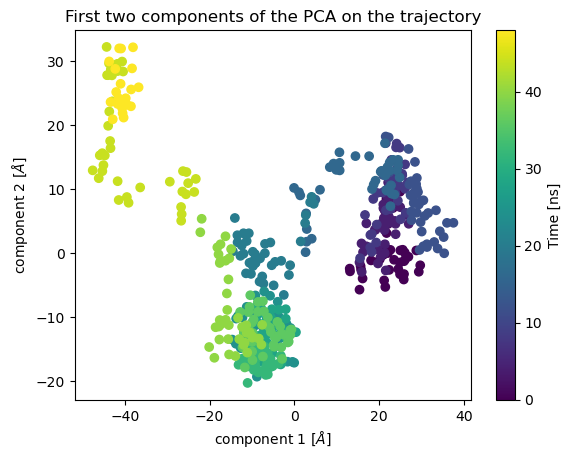

In [50]:
plt.title("First two components of the PCA on the trajectory")
scatter = plt.scatter(pca_data['first_comp'], pca_data['second_comp'], c=pca_data['group'])
plt.xlabel(r"component 1 $[\AA]$")
plt.ylabel(r"component 2 $[\AA]$")
plt.colorbar(scatter, label = 'Time [ns]')